# Diagram

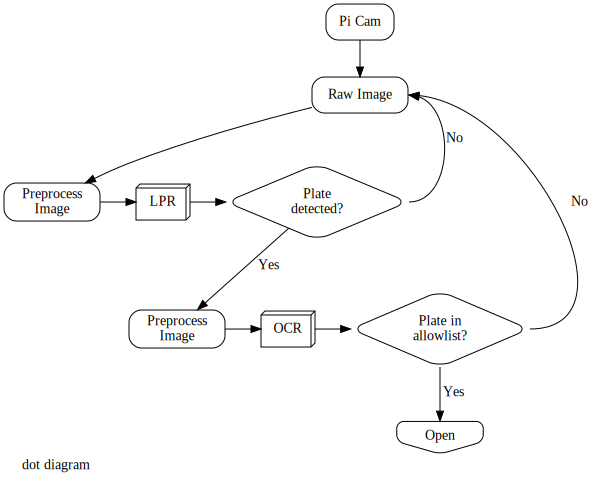

In [1]:
import graphviz

dot = graphviz.Digraph()

dot.attr('graph', labeljust='l', label='dot diagram', rankdir='TB')
dot.attr('node', shape='rect', style='rounded')
dot.engine = 'dot'

# graphviz.__version__, graphviz.version()

dot.node('cam', 'Pi Cam')
dot.node('img', 'Raw Image', shape='box')
dot.edge('cam:s', 'img:n')

with dot.subgraph(name='nocluster_0') as c:
    c.attr('graph', labeljust='l', label='LPR')
    c.attr(rank='same')

    c.node('pp1', 'Preprocess\n Image')
    c.node('lpr', 'LPR', shape='box3d')
    c.node('stage1', 'Plate\n detected?', shape='diamond')
    
    c.edge('pp1', 'lpr')#, constraint='false')


with dot.subgraph(name='nocluster_1') as c:
    c.attr('graph', labeljust='l', label='OCR')
    c.attr(rank='same')

    c.node('pp2', 'Preprocess\n Image')
    c.node('ocr', 'OCR', shape='box3d')
    c.node('stage2', 'Plate in\n allowlist?', shape='diamond')

    c.edge('pp2', 'ocr')


dot.node('open', 'Open', shape='invhouse')


dot.edge('img', 'pp1')
dot.edge('lpr', 'stage1')

dot.edge('stage1', 'pp2', label='Yes')
dot.edge('stage1:e', 'img:e', label='No')

dot.edge('ocr', 'stage2')
dot.edge('stage2:e', 'img:e', label='No')
dot.edge('stage2:s', 'open', label='Yes')


dot

In [2]:
from pprint import pprint
from pathlib import Path

example_dir = Path('./data/valid')
oid = 'f5d1729aa333b284_jpg.rf.0a241e6c8cfebc2ee5a5a931954e5da7'

example_img = example_dir / f'{oid}.jpg'
example_xml = example_dir / f'{oid}.xml'
example_txt = example_dir / f'{oid}.txt'

# Preprocess Image

In [3]:
from matplotlib import pyplot as plt
import cv2

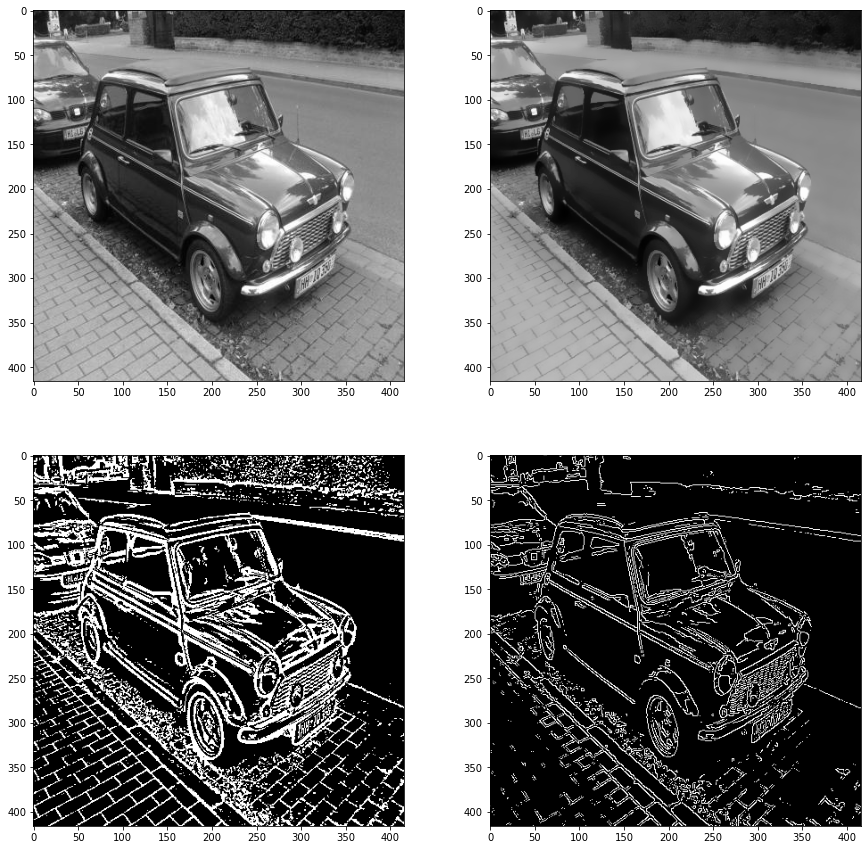

In [4]:
img = cv2.imread(str(example_img))

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#blur = cv2.GaussianBlur(gray,(3,3),0)
blur = cv2.bilateralFilter(gray, 13, 15, 15)

thresh = cv2.adaptiveThreshold(blur,
    255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3)
edge = cv2.Canny(blur, threshold1=123, threshold2=123)
 

## dilation for letters
#kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes[0,0].imshow(img)
axes[0,1].imshow(blur, cmap='gray')
axes[1,0].imshow(thresh, cmap='gray')
axes[1,1].imshow(edge, cmap='gray')
plt.show()

# Open Images Dataset

In [5]:
import pandas as pd
import numpy as np

classes = pd.read_csv('./data/class-descriptions-boxable.csv', names=['id', 'label'])
boxes = pd.read_csv('./data/validation-annotations-bbox.csv')

labels = [
    'Car',
    'Vehicle registration plate'
]
label_ids = list(classes.loc[classes['label'].isin(labels)]['id'])
label_ids

['/m/01jfm_', '/m/0k4j']

In [6]:
boxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303980 entries, 0 to 303979
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ImageID      303980 non-null  object 
 1   Source       303980 non-null  object 
 2   LabelName    303980 non-null  object 
 3   Confidence   303980 non-null  int64  
 4   XMin         303980 non-null  float64
 5   XMax         303980 non-null  float64
 6   YMin         303980 non-null  float64
 7   YMax         303980 non-null  float64
 8   IsOccluded   303980 non-null  int64  
 9   IsTruncated  303980 non-null  int64  
 10  IsGroupOf    303980 non-null  int64  
 11  IsDepiction  303980 non-null  int64  
 12  IsInside     303980 non-null  int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 30.1+ MB


In [7]:
cols = ['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']
boxes_filtered = boxes.loc[
    (boxes['LabelName'].isin(label_ids)) &
    (boxes['IsOccluded'] == 0) &
    (boxes['IsTruncated'] == 0) &
    (boxes['IsDepiction'] == 0) &
    (boxes['IsInside'] == 0)
][cols]
boxes_filtered

,ImageID,LabelName,XMin,XMax,YMin,YMax
102,001083f05db4352b,/m/0k4j,0.164062,0.767188,0.337500,0.822500
217,001a794d1865ee47,/m/0k4j,0.293706,0.934266,0.023310,0.890443
218,001a809ad40a2f84,/m/0k4j,0.085938,0.878125,0.167015,0.878914
256,00230c216711fceb,/m/0k4j,0.069219,0.948454,0.419069,0.946785
270,003132be85a0beae,/m/0k4j,0.047267,0.895126,0.291391,0.847682
...,...,...,...,...,...,...
303896,ffe8c9d078bef363,/m/0k4j,0.082812,0.942187,0.031250,0.997917
303911,ffeb8b72409f2964,/m/0k4j,0.247496,0.869814,0.293850,0.785877
303955,fff2268a1b921e8e,/m/01jfm_,0.181818,0.202171,0.031250,0.060096
303956,fff2268a1b921e8e,/m/01jfm_,0.229308,0.354138,0.622596,0.798077


In [8]:
t = boxes_filtered.groupby(['ImageID']).get_group('fff2268a1b921e8e')
for idx, label in t.iterrows():
    print(label)

ImageID      fff2268a1b921e8e
LabelName           /m/01jfm_
XMin                 0.181818
XMax                 0.202171
YMin                  0.03125
YMax                 0.060096
Name: 303955, dtype: object
ImageID      fff2268a1b921e8e
LabelName           /m/01jfm_
XMin                 0.229308
XMax                 0.354138
YMin                 0.622596
YMax                 0.798077
Name: 303956, dtype: object
ImageID      fff2268a1b921e8e
LabelName           /m/01jfm_
XMin                 0.563094
XMax                 0.573948
YMin                 0.014423
YMax                 0.026442
Name: 303957, dtype: object


In [10]:
num_images = 10
samples = np.random.choice(boxes_filtered['ImageID'].unique(), num_images, replace=False)

dataset = boxes_filtered.loc[boxes_filtered['ImageID'].isin(samples)]
dataset

,ImageID,LabelName,XMin,XMax,YMin,YMax
25674,15a51e29f5ceffd8,/m/01jfm_,0.418879,0.569322,0.570797,0.690265
27372,174852927c18c2c7,/m/0k4j,0.000000,0.720313,0.404167,0.979167
42639,240fba52ee2bad54,/m/0k4j,0.251563,0.703125,0.239583,0.770833
63845,35edb10155ba1b02,/m/0k4j,0.040625,0.965625,0.129167,0.877083
67785,39079f7c39935789,/m/0k4j,0.289062,0.835938,0.168750,0.837500
82861,45929bfb9593c365,/m/0k4j,0.025000,0.986765,0.212860,0.760532
119210,645bda49cc66beaa,/m/0k4j,0.075000,0.973529,0.006652,0.957871
191313,a1011a724439eeb7,/m/0k4j,0.044234,0.958926,0.045361,0.977320
245930,ce97f7bc90e97109,/m/0k4j,0.088235,0.925000,0.152993,0.940133
245931,ce97f7bc90e97109,/m/0k4j,0.879412,0.922059,0.179601,0.226164


In [20]:
t = boxes_filtered.groupby(['ImageID']).get_group('fff2268a1b921e8e')
for idx, label in t.iterrows():
    print(label)

ImageID      fff2268a1b921e8e
LabelName           /m/01jfm_
XMin                 0.181818
XMax                 0.202171
YMin                  0.03125
YMax                 0.060096
Name: 303955, dtype: object
ImageID      fff2268a1b921e8e
LabelName           /m/01jfm_
XMin                 0.229308
XMax                 0.354138
YMin                 0.622596
YMax                 0.798077
Name: 303956, dtype: object
ImageID      fff2268a1b921e8e
LabelName           /m/01jfm_
XMin                 0.563094
XMax                 0.573948
YMin                 0.014423
YMax                 0.026442
Name: 303957, dtype: object


In [14]:
def write_yolo_bbox(image_path, labels):
    yolo = []
    if os.path.isfile(image_path):
        txt = image_path.with_suffix('.txt')
        txt.unlink() # delete (old) before writing?
    else:
        print(f'File not found: {str(image_path)}')
        return
    for idx, label in labels.iterrows():
        x_min, x_max, y_min, y_max = (
            label['XMin'],
            label['XMax'],
            label['YMin'],
            label['YMax'],
        )
        label = 0
        yolo.append(' '.join([
                str(label),
                str(round((x_max+x_min)/2, 6)),
                str(round((y_max+y_min)/2, 6)),
                str(round( x_max-x_min,    6)),
                str(round( y_max-y_min,    6)) + '\n'
                ]))
    with open('test.txt', "w") as f:
        f.writelines(yolo)

# XML (Pascal VOC) to YOLO

In [ ]:
from xml.dom import minidom
import os
import glob

In [ ]:
class XML2YOLO:
    
    lut = {
           'license-plate': 0,
           'vehicle':       1,
    }
    
    verbose = False
    
    def __init__(self):
        pass
    
    def convert_coordinates(self, size, box):
        dw = 1.0/size[0]
        dh = 1.0/size[1]
        x = (box[0]+box[1])/2.0
        y = (box[2]+box[3])/2.0
        w = box[1]-box[0]
        h = box[3]-box[2]
        x = x*dw
        w = w*dw
        y = y*dh
        h = h*dh
        return (x,y,w,h)

    def convert(self, infile, outfile):
        xmldoc = minidom.parse(infile)

        with open(outfile, "w") as f:

            itemlist = xmldoc.getElementsByTagName('object')
            size = xmldoc.getElementsByTagName('size')[0]
            width = int((size.getElementsByTagName('width')[0]).firstChild.data)
            height = int((size.getElementsByTagName('height')[0]).firstChild.data)

            for item in itemlist:
                
                # get bbox coordinates
                xmin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmin')[0]).firstChild.data
                ymin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymin')[0]).firstChild.data
                xmax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmax')[0]).firstChild.data
                ymax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymax')[0]).firstChild.data
                b = (float(xmin), float(xmax), float(ymin), float(ymax))
                bb = self.convert_coordinates((width,height), b)
                
                # get class label
                classid =  (item.getElementsByTagName('name')[0]).firstChild.data
                if classid in self.lut:
                    label_str = str(self.lut[classid])
                    f.write(label_str + " " + " ".join([("%.6f" % a) for a in bb]) + '\n')
                else:
                    label_str = "-1"
                    if self.verbose:
                        print("warning: label '%s' not in look-up table" % classid)

        if self.verbose:
            print("wrote %s" % outfile)

    def convert_dir(self, directory):
        xmls = directory.glob('*.xml')
        for xml in xmls:
            txt = directory / f'{xml.stem}.txt'
            self.convert(str(xml), str(txt))
        

In [ ]:
# from pathlib import Path
# import cv2

# dirs = ['valid', 'train', 'test']
# converter = XML2YOLO()
# #converter.verbose = True

# for d in dirs:
#     path = Path('./lpr/roboflow-dataset') / d
#     converter.convert_dir(path)
#     for pic in path.glob('*.jpg'):
#         img = cv2.imread(str(pic))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         cv2.imwrite(str(pic), img)